In [1]:
import os
import numpy as np
from scipy.stats import kendalltau
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from geomloss import SamplesLoss
from sklearn.model_selection import KFold
import rouge
import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from config_models import *
from datasets import *
from models import *
from preprocessing import *

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

torch.manual_seed(42)
torch.set_default_tensor_type(torch.cuda.DoubleTensor)

[nltk_data] Downloading package punkt to /home/korunosk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
DATASET_ID_TRAIN = DATASET_IDS[0]
DATASET_ID_TEST = DATASET_IDS[1]
TOPIC_ID_TRAIN = TOPIC_IDS[DATASET_ID_TRAIN][0]
TOPIC_ID_TEST = TOPIC_IDS[DATASET_ID_TEST][0]
BASE_DATA_DIR = '/scratch/korunosk/data'
PLOTS_DIR = 'plots'
MODELS_DIR = 'models'
EMBEDDINGS_DIR = os.path.join(BASE_DATA_DIR, 'BERT_sent')

#### For all topics

In [3]:
# tuples_data = []
# for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
#     tuples_data.extend(make_tuples_data_for_regression(EMBEDDINGS_DIR, DATASET_ID_TRAIN, topic_id))
# tuples_data = np.array(tuples_data)

# tuples_train_regression, tuples_val_regression = leave_n_out(tuples_data)

# tuples_train_regression.shape, tuples_val_regression.shape

In [4]:
# tuples_data = []
# for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
#     tuples_data.extend(make_tuples_data_for_classification(EMBEDDINGS_DIR, DATASET_ID_TRAIN, topic_id))
# tuples_data = np.array(tuples_data)

# tuples_train_classification, tuples_test_classification = leave_n_out(tuples_data)
# tuples_train_classification, tuples_val_classification = leave_n_out(tuples_train_classification, test_size=0.1)

# tuples_train_classification.shape, tuples_val_classification.shape, tuples_test_classification.shape

# Learning transformation

In [5]:
# config = CONFIG_MODELS['TransformSinkhornRegModel']

# transform = transforms.Compose([Normalize(), ToTensor()])
# dataset = TACDatasetRegression(BASE_DATA_DIR, EMBEDDINGS_DIR, DATASET_ID_TRAIN, tuples_train_regression)
# data_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=lambda x: x)

# transform_sinkhorn_reg_model = TransformSinkhornRegModel(config).cuda()

# criterion = nn.MSELoss()
# optimizer = optim.SGD(transform_sinkhorn_reg_model.parameters(), lr=config['learning_rate'])

# loss = []

# for batch in data_loader:
#     L = 0.0
    
#     for sample in batch:
#         (d, s), y = transform(sample)

#         L += criterion(transform_sinkhorn_reg_model(d, s), y)
        
#         optimizer.step()

#     loss.append(L.item())
#     print(f'{loss[-1]:.4f}')

#     optimizer.zero_grad()

#     L.backward()

# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(1,1,1)
# plot_loss(ax, loss)
# plt.show()

In [6]:
# M = list(transform_sinkhorn_reg_model.parameters())[0].data.cpu().numpy()
# np.save(os.path.join(MODELS_DIR, 'transform_sinkhorn_reg_model.npy'), M)

In [7]:
# config = CONFIG_MODELS['TransformSinkhornPRModel']

# transform = transforms.Compose([Normalize(), ToTensor()])
# dataset = TACDatasetClassification(BASE_DATA_DIR, EMBEDDINGS_DIR, DATASET_ID_TRAIN, tuples_train_classification)
# data_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=lambda x: x)

# transform_sinkhorn_pr_model = TransformSinkhornPRModel(config).cuda()

# criterion = nn.BCELoss()
# optimizer = optim.SGD(transform_sinkhorn_pr_model.parameters(), lr=config['learning_rate'])

# loss = []

# for batch in data_loader:
#     L = 0.0
    
#     for sample in batch:
#         (d, s1, s2), y = transform(sample)
                
#         L += criterion(transform_sinkhorn_pr_model(d, s1, s2), y)
        
#         optimizer.step()
        
#     loss.append(L.item())
#     print(f'{loss[-1]:.4f}')
    
#     optimizer.zero_grad()

#     L.backward()
    
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(1,1,1)
# plot_loss(ax, loss)
# plt.show()

In [8]:
# M = list(transform_sinkhorn_pr_model.parameters())[0].data.cpu().numpy()
# np.save(os.path.join(MODELS_DIR, 'transform_sinkhorn_pr_model.npy'), M)

In [9]:
# config = CONFIG_MODELS['NeuralNetSinkhornPRModel']

# transform = transforms.Compose([Normalize(), ToTensor()])
# dataset = TACDatasetClassification(BASE_DATA_DIR, EMBEDDINGS_DIR, DATASET_ID_TRAIN, tuples_train_classification)
# data_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=lambda x: x)

# neural_net_sinkhorn_pr_model = NeuralNetSinkhornPRModel(config).cuda()

# criterion = nn.BCELoss()
# optimizer = optim.SGD(neural_net_sinkhorn_pr_model.parameters(), lr=config['learning_rate'])

# loss = []

# for batch in data_loader:
#     L = 0.0
    
#     for sample in batch:
#         (d, s1, s2), y = transform(sample)
                
#         L += criterion(neural_net_sinkhorn_pr_model(d, s1, s2), y)
        
#         optimizer.step()
        
#     loss.append(L.item())
#     print(f'{loss[-1]:.4f}')
    
#     optimizer.zero_grad()

#     L.backward()
    
# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(1,1,1)
# plot_loss(ax, loss)
# plt.show()

In [10]:
# torch.save(neural_net_sinkhorn_pr_model.state_dict(), os.path.join(MODELS_DIR, 'neural_net_sinkhorn_pr_model.pt'))

# Scoring

In [11]:
# config = CONFIG_MODELS['NeuralNetScoringPRModel']

# transform = transforms.Compose([ToTensor()])
# dataset = TACDatasetClassification(BASE_DATA_DIR, EMBEDDINGS_DIR, DATASET_ID_TRAIN, tuples_train_classification)
# data_loader = DataLoader(dataset, batch_size=config['batch_size'], collate_fn=lambda x: x)

# neural_net_scoring_pr_model = NeuralNetScoringPRModel(config).cuda()

# criterion = nn.BCELoss()
# optimizer = optim.SGD(neural_net_scoring_pr_model.parameters(), lr=config['learning_rate'])

# loss = []

# for batch in data_loader:
#     L = 0.0

#     for sample in batch:
#         (d, s1, s2), y = transform(sample)
        
#         L += criterion(neural_net_scoring_pr_model(d, s1, s2), y).div(config['batch_size'])

#         optimizer.step()

#     loss.append(L.item())
#     print(f'{loss[-1]:4f}')

#     optimizer.zero_grad()

#     L.backward()


# fig = plt.figure(figsize=(10,5))
# ax = fig.add_subplot(1,1,1)
# plot_loss(ax, loss)
# plt.show()

In [12]:
# torch.save(neural_net_scoring_pr_model.state_dict(), os.path.join(MODELS_DIR, 'neural_net_scoring_pr_model.pt'))

## Visualizations

In [13]:
# document_embs, summary_embs, indices, pyr_scores, _ = data_encoded_train
# m = np.argsort(-np.array(pyr_scores))

# x, y = np.array(pyr_scores)[m], []

# d = torch.tensor(document_embs).mean(axis=0)
# for i in np.array(indices)[m]:
#     s = torch.tensor(summary_embs[i[0]:i[1]])
#     y.append(model.score(d, s).cpu().data.numpy())

# fig = plt.figure(figsize=(10,10))
# ax = fig.add_subplot(1,1,1)
# ax.scatter(x, y)
# ax.set_title(f'Correlation: {kendalltau(x, y)[0]:.2f}')
# ax.set_xlabel('Pyramid')
# ax.set_ylabel('NN Score')
# plt.show()

In [14]:
# sinkhorn = SamplesLoss(loss='sinkhorn', p=2, blur=.05, scaling=.9)

In [9]:
# def experiment_transform_sinkhorn(data, M):
#     document_embs, summary_embs, indices, pyr_scores, summary_ids = data
#     M = torch.tensor(M)
#     document_embs = torch.mm(torch.tensor(document_embs), M)
#     summary_embs = torch.mm(torch.tensor(summary_embs), M)
#     metric = lambda i: sinkhorn(document_embs, summary_embs[i[0]:i[1]])
#     return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

# def experiment_neural_net_sinkhorn(data, model):
#     document_embs, summary_embs, indices, pyr_scores, summary_ids = data
#     document_embs = model.predict(torch.tensor(document_embs))
#     summary_embs = model.predict(torch.tensor(summary_embs))
#     metric = lambda i: sinkhorn(document_embs, summary_embs[i[0]:i[1]])
#     return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

# def experiment_neural_net_scoring(data, model):
#     document_embs, summary_embs, indices, pyr_scores, summary_ids = data
#     document_embs = torch.tensor(document_embs)
#     summary_embs = torch.tensor(summary_embs)
#     metric = lambda i: model.score(document_embs, summary_embs[i[0]:i[1]])
#     return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

In [10]:
# def execute(experiment):
#     scores = []
#     for topic_id in TOPIC_IDS[DATASET_ID_TRAIN]:
#         print(topic_id)
#         topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
#         data = extract(topic)
#         scores.append(experiment(data))
#     return np.array(scores)

In [12]:
# print('transform_sinkhorn_reg_model')
# M = np.load(os.path.join(MODELS_DIR, 'transform_sinkhorn_reg_model.npy'))
# scores_transform_sinkhorn_reg_model = execute(lambda data: experiment_transform_sinkhorn(data, M))

# print('transform_sinkhorn_pr_model')
# M = np.load(os.path.join(MODELS_DIR, 'transform_sinkhorn_pr_model.npy'))
# scores_transform_sinkhorn_pr_model = execute(lambda data: experiment_transform_sinkhorn(data, M))

# print('neural_net_sinkhorn_pr_model')
# config = CONFIG_MODELS['NeuralNetSinkhornPRModel']
# neural_net_sinkhorn_pr_model = NeuralNetSinkhornPRModel(config).cuda()
# neural_net_sinkhorn_pr_model.load_state_dict(torch.load(os.path.join(MODELS_DIR, 'neural_net_sinkhorn_pr_model.pt')))
# neural_net_sinkhorn_pr_model.eval()
# scores_neural_net_sinkhorn_pr_model = np.array(execute(lambda data: experiment_neural_net_sinkhorn(data, neural_net_sinkhorn_pr_model)))

# print('neural_net_scoring_pr_model')
# config = CONFIG_MODELS['NeuralNetScoringPRModel']
# neural_net_scoring_pr_model = NeuralNetScoringPRModel(config).cuda()
# neural_net_scoring_pr_model.load_state_dict(torch.load(os.path.join(MODELS_DIR, 'neural_net_scoring_pr_model.pt')))
# neural_net_scoring_pr_model.eval()
# scores_neural_net_scoring_pr_model = np.array(execute(lambda data: experiment_neural_net_scoring(data, neural_net_scoring_pr_model)))

In [18]:
# topics = TOPIC_IDS[DATASET_ID_TRAIN]
# x = np.arange(len(topics))
# fig = plt.figure(figsize=(17.5,5))
# ax = fig.add_subplot(1,1,1)
# ax.plot(x, -scores_transform_sinkhorn_reg_model, '-o', label=f'Transform-Sinkhorn-Reg: {np.mean(-scores_transform_sinkhorn_reg_model):.2}')
# ax.plot(x, -scores_transform_sinkhorn_pr_model, '-s', label=f'Transform-Sinkhorn-PR: {np.mean(-scores_transform_sinkhorn_pr_model):.2}')
# ax.plot(x, -scores_neural_net_sinkhorn_pr_model, '-^', label=f'NeuralNet-Sinkhorn-PR: {np.mean(-scores_neural_net_sinkhorn_pr_model):.2}')
# ax.plot(x, scores_neural_net_scoring_pr_model, '-x', label=f'NeuralNet-Scoring-PR: {np.mean(scores_neural_net_scoring_pr_model):.2}')
# ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
# ax.set_xticks(x)
# ax.set_xticklabels(topics, rotation=45)
# ax.set_xlabel('Topic')
# ax.set_ylabel('Kendall tau')
# ax.legend(loc='best')
# fig.savefig(os.path.join(PLOTS_DIR, f'models_correlation.png'), dpi=fig.dpi, bbox_inches='tight')

In [19]:
# document_embs, summary_embs, indices, pyr_scores, _ = data_encoded_train

# m = np.argsort(-np.array(pyr_scores))

# b, w = 0, -1

# fig = plt.figure(figsize=(20,20))

# document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), len(document_embs))

# ax1 = fig.add_subplot(2,2,1)
# plot_hull(ax1, 'Summary with highest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
# ax2 = fig.add_subplot(2,2,2)
# plot_hull(ax2, 'Summary with lowest Pyramid score in original space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

# document_pts, summary_pts = project_pca(np.concatenate((document_embs @ M, summary_embs @ M)), len(document_embs))

# ax3 = fig.add_subplot(2,2,3)
# plot_hull(ax3, 'Summary with highest Pyramid score in embedded space', 'pca', document_pts, summary_pts[indices[m[b]][0]:indices[m[b]][1]])
# ax4 = fig.add_subplot(2,2,4)
# plot_hull(ax4, 'Summary with lowest Pyramid score in embedded space', 'pca', document_pts, summary_pts[indices[m[w]][0]:indices[m[w]][1]])

# plt.show()

In [3]:
cuda = torch.device('cuda:0')

In [5]:
topic_ids = np.array(TOPIC_IDS[DATASET_ID_TRAIN])

tuples_data = []
for topic_id in topic_ids:
    tuples_data.extend(make_tuples_data_for_classification(EMBEDDINGS_DIR, DATASET_ID_TRAIN, topic_id))
tuples_data = np.array(tuples_data)

tuples_data

array([['D0841', '0', '1', '0'],
       ['D0841', '0', '2', '0'],
       ['D0841', '0', '3', '0'],
       ...,
       ['D0811', '61', '58', '1'],
       ['D0811', '61', '59', '1'],
       ['D0811', '61', '60', '1']], dtype='<U5')

In [4]:
class NeuralNetSinkhornPRModel(nn.Module):
    def __init__(self, config):
        super(NeuralNetSinkhornPRModel, self).__init__()
        self.config = config
        self.sinkhorn = SamplesLoss(loss='sinkhorn', p=self.config['p'], blur=self.config['blur'], scaling=self.config['scaling'])
        self.layer = nn.Linear(self.config['D_in'], self.config['D_out'])
        self.sigm = nn.Sigmoid()
    
    def transform(self, x):
        return F.relu(self.layer(x))
    
    def predict(self, d, s):
        return self.sinkhorn(self.transform(d), self.transform(s))

    def forward(self, d, s1, s2):
        dist1 = self.predict(d, s1)
        dist2 = self.predict(d, s2)
        return self.sigm(self.config['scaling_factor'] * (dist2 - dist1))

config = CONFIG_MODELS['NeuralNetSinkhornPRModel']

transform = transforms.Compose([Normalize(), ToTensor()])

for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):
    
    topics_train = topic_ids[train_index]
    topics_test  = topic_ids[test_index]

    tuples_train = tuples_data[np.isin(tuples_data[:,0], topics_train)]
    tuples_test  = tuples_data[np.isin(tuples_data[:,0], topics_test)]
    
    dataset_train = TACDatasetClassification(BASE_DATA_DIR, EMBEDDINGS_DIR, DATASET_ID_TRAIN, tuples_train)

    neural_net_sinkhorn_pr_model = NeuralNetSinkhornPRModel(config).cuda()

    criterion = nn.BCELoss()
    optimizer = optim.SGD(neural_net_sinkhorn_pr_model.parameters(), lr=config['learning_rate'])

    loss = []
    
    data_loader_train = DataLoader(dataset_train, batch_size=config['batch_size'], collate_fn=lambda x: x)

    for i, batch in enumerate(data_loader_train):
        if i % 100 == 0:
            if loss:
                print(f'Train Loss: {loss[-1]:.4f}')
        
        optimizer.zero_grad()
        
        L = 0.0

        for sample in batch:
            (d, s1, s2), y = transform(sample)

            L += criterion(neural_net_sinkhorn_pr_model(d, s1, s2), y)

            optimizer.step()

        loss.append(L.item())

        L.backward()
        
    torch.save(neural_net_sinkhorn_pr_model.state_dict(), os.path.join(MODELS_DIR, f'neural_net_sinkhorn_pr_model_cv_{model_num + 1}.pt'))

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    plot_loss(ax, loss)
    plt.show()

In [7]:
from collections import defaultdict

def make(shape, t, val):
    target = np.zeros(shape=shape)
    target[:t] = val
    return target

M = 20
N = 768

dataset = defaultdict(dict)

for topic_id in topic_ids:
    topic = load_data(os.path.join(EMBEDDINGS_DIR, DATASET_ID_TRAIN), topic_id, encoded=True)
    document_embs, summary_embs, indices, pyr_scores, summ_ids = extract(topic)
    
    d = np.array(document_embs).mean(axis=0).reshape(1,-1).repeat(M, axis=0)
    s = np.stack([make((M,N), i[1]-i[0], summary_embs[i[0]:i[1]]) for i in indices])
    m = np.stack([make((M,1), i[1]-i[0], 1) for i in indices])
    p = np.array(pyr_scores)
    i = np.array(summ_ids)
    
    dataset[topic_id]['d'] = d
    dataset[topic_id]['s'] = s
    dataset[topic_id]['m'] = m
    dataset[topic_id]['p'] = p
    dataset[topic_id]['i'] = i

class TACDatasetClassification(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        topic_id = self.data[idx][0]
        
        i1 = int(self.data[idx][1])
        i2 = int(self.data[idx][2])
        
        d  = dataset[topic_id]['d']
        s1 = dataset[topic_id]['s'][i1]
        s2 = dataset[topic_id]['s'][i2]
        m1 = dataset[topic_id]['m'][i1]
        m2 = dataset[topic_id]['m'][i2]
        y  = float(self.data[idx][3])
        
        return self.transform((d, s1, s2, m1, m2, y))

class ToTensor():
    def __call__(self, sample):
        d, s1, s2, m1, m2, y = sample
        
        d  = torch.tensor(d,  dtype=torch.float)
        s1 = torch.tensor(s1, dtype=torch.float)
        s2 = torch.tensor(s2, dtype=torch.float)
        m1 = torch.tensor(m1, dtype=torch.bool)
        m2 = torch.tensor(m2, dtype=torch.bool)
        y  = torch.tensor(y,  dtype=torch.float)
        
        return d, s1, s2, m1, m2, y
    
class NeuralNetScoringPRModel(nn.Module):
    def __init__(self, config):
        super(NeuralNetScoringPRModel, self).__init__()
        self.config = config
        self.layer1 = nn.Linear(self.config['D_in'], self.config['H'])
        self.layer2 = nn.Linear(self.config['D_in'], 1)
        self.sigm = nn.Sigmoid()
    
    def predict(self, x):
        return self.layer2(F.relu(self.layer1(x)))
    
    def score_masking(self, d, s, m):
        x = torch.cat((d, s), axis=2)
        z = self.predict(x)
        return torch.sum(z * m, axis=1)
    
    def score_selection(self, d, s, m):
        x = torch.cat((d, s), axis=2)
        z = self.predict(x)
        return torch.stack([ torch.sum(z[i].masked_select(m[i])) for i in range(z.shape[0]) ])
    
    def validate(self, d, s1, s2, m1, m2):
        score1 = self.score_masking(d, s1, m1)
        score2 = self.score_masking(d, s2, m2)
        return self.sigm(self.config['scaling_factor'] * (score1 - score2))
    
    def forward(self, d, s1, s2, m1, m2):
        score1 = self.score_selection(d, s1, m1)
        score2 = self.score_selection(d, s2, m2)
        return self.sigm(self.config['scaling_factor'] * (score1 - score2))


def auc(model, dataset):
    s = time.time()

    model.eval()

    data_loader = DataLoader(dataset, batch_size=10000, num_workers=24, shuffle=True)

    L = 0.0

    for batch in data_loader:
        d, s1, s2, m1, m2, y = batch

        y_hat = model.validate(d.to(device=cuda),
                               s1.to(device=cuda),
                               s2.to(device=cuda),
                               m1.to(device=cuda),
                               m2.to(device=cuda))
        y_hat = y_hat.squeeze()

        y_hat = y_hat > 0.5

        L += (y_hat == y.to(device=cuda)).sum().item()

    L /= len(dataset)

    model.train()

    print(f'AUC: {L:.4f} Time: {(time.time() - s):.4f}')


def calc_loss(model, dataset):    
    s = time.time()

    model.eval()

    data_loader = DataLoader(dataset, batch_size=10000, num_workers=24, shuffle=True)

    L = 0.0

    for batch in data_loader:
        d, s1, s2, m1, m2, y = batch

        y_hat = model.validate(d.to(device=cuda),
                               s1.to(device=cuda),
                               s2.to(device=cuda),
                               m1.to(device=cuda),
                               m2.to(device=cuda))
        y_hat = y_hat.squeeze()

        L += criterion(y_hat, y.to(device=cuda)).item()

    L /= len(dataset)

    model.train()

    print(f'Loss: {L:.4f} Time: {(time.time() - s):.4f}')

config = {
    'D_in': 1536,
    'H': 1536,
    'scaling_factor': 1,
    'learning_rate': 1e-4,
    'batch_size': 256
}

transform = transforms.Compose([ToTensor()])

for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):
    
    topics_train = topic_ids[train_index]
    topics_test  = topic_ids[test_index]

    tuples_train = tuples_data[np.isin(tuples_data[:,0], topics_train)]
    tuples_test  = tuples_data[np.isin(tuples_data[:,0], topics_test)]

    dataset_train = TACDatasetClassification(tuples_train, transform)
    dataset_test  = TACDatasetClassification(tuples_test, transform)

    neural_net_scoring_pr_model = NeuralNetScoringPRModel(config).to(device=cuda)

    criterion = nn.BCELoss(reduction='sum')
    optimizer = optim.Adam(neural_net_scoring_pr_model.parameters(), lr=config['learning_rate'])

    neural_net_scoring_pr_model.train()

    loss = []

    for epoch in range(2):
        print(f'Epoch: {epoch + 1}')

        data_loader_train = DataLoader(dataset_train, batch_size=config['batch_size'], num_workers=24, shuffle=True)

        for i, batch in enumerate(data_loader_train):            
            if i % 100 == 0:
                if loss:
                    print(f'Train Loss: {loss[-1]:.4f}')

            optimizer.zero_grad()

            d, s1, s2, m1, m2, y = batch

            y_hat = neural_net_scoring_pr_model(d.to(device=cuda),
                                                s1.to(device=cuda),
                                                s2.to(device=cuda),
                                                m1.to(device=cuda),
                                                m2.to(device=cuda))
            y_hat = y_hat.squeeze()

            L = criterion(y_hat, y.to(device=cuda)).div(config['batch_size'])

            L.backward()

            optimizer.step()

            loss.append(L.item())

    neural_net_scoring_pr_model.eval()
    
    torch.save(neural_net_scoring_pr_model.state_dict(), os.path.join(MODELS_DIR, f'neural_net_scoring_pr_model_cv_{model_num + 1}.pt'))

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1,1,1)
    plot_loss(ax, loss)
    plt.show()

In [31]:
def load_neural_net_scoring_pr_model(config, model_num):
    neural_net_scoring_pr_model = NeuralNetScoringPRModel(config).cuda()
    neural_net_scoring_pr_model.load_state_dict(torch.load(os.path.join(MODELS_DIR, f'neural_net_scoring_pr_model_cv_{model_num}.pt')))
    neural_net_scoring_pr_model.eval()
    return neural_net_scoring_pr_model

In [32]:
def calculate_scores(model, topic_ids):
    scores = []
    with torch.no_grad():
        for topic_id in topic_ids:
            topic = dataset[topic_id]
            d = torch.tensor(topic['d'], dtype=torch.float).to(cuda)
            s = torch.tensor(topic['s'], dtype=torch.float).to(cuda)
            m = torch.tensor(topic['m'], dtype=torch.bool).to(cuda)
            d = d.repeat(s.shape[0], 1, 1)
            scores.append(kendalltau(topic['p'], model.score_masking(d,s,m).cpu())[0])
    return scores

In [33]:
neural_net_scoring_pr_models = [
    load_neural_net_scoring_pr_model(config, 1),
    load_neural_net_scoring_pr_model(config, 2),
    load_neural_net_scoring_pr_model(config, 3)
]

In [34]:
neural_net_scoring_pr_model_scores = [
    calculate_scores(neural_net_scoring_pr_models[0], topic_ids),
    calculate_scores(neural_net_scoring_pr_models[1], topic_ids),
    calculate_scores(neural_net_scoring_pr_models[2], topic_ids)
]

In [43]:
scores = []
for model_num, (train_index, test_index) in enumerate(KFold(n_splits=3).split(topic_ids)):
    topics_test = topic_ids[test_index]
    neural_net_scoring_pr_model = neural_net_scoring_pr_models[model_num]
    scores.extend(calculate_scores(neural_net_scoring_pr_model, topics_test))
np.mean(scores)

0.2596691294241111

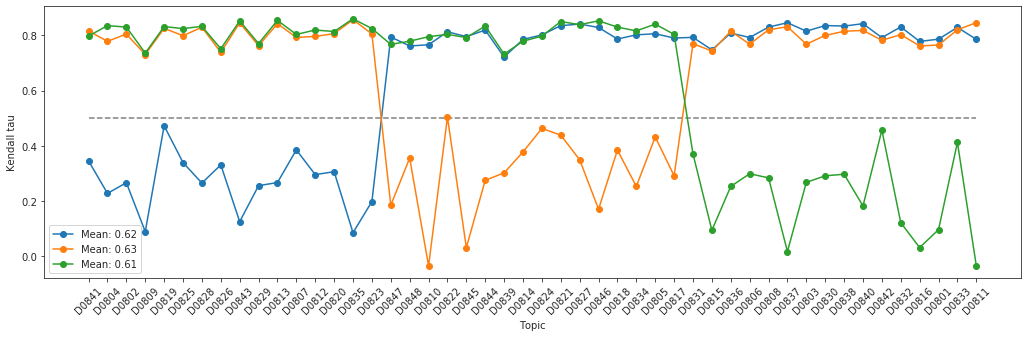

In [35]:
x = np.arange(len(dataset.keys()))
fig = plt.figure(figsize=(17.5,5))
ax = fig.add_subplot(1,1,1)
ax.plot(x, neural_net_scoring_pr_model_scores[0], '-o', label=f'Mean: {np.mean(neural_net_scoring_pr_model_scores[0]):.2}')
ax.plot(x, neural_net_scoring_pr_model_scores[1], '-o', label=f'Mean: {np.mean(neural_net_scoring_pr_model_scores[1]):.2}')
ax.plot(x, neural_net_scoring_pr_model_scores[2], '-o', label=f'Mean: {np.mean(neural_net_scoring_pr_model_scores[2]):.2}')
ax.hlines(0.5, x[0], x[-1], linestyle='dashed', color='gray')
ax.set_xticks(x)
ax.set_xticklabels(dataset.keys(), rotation=45)
ax.set_xlabel('Topic')
ax.set_ylabel('Kendall tau')
ax.legend(loc='best')
plt.show()

In [15]:
def get_reference_summaries(summaries, indices, summ_ids):
    reference_summaries = []
    for i, summ_id in enumerate(summ_ids):
        try:
            int(summ_id, 10)
        except:
            reference_summaries.extend(summaries[indices[i][0]:indices[i][1]])
    return reference_summaries

In [16]:
topic = load_data(BASE_DATA_DIR, DATASET_ID_TRAIN, encoded=False)['D0841']
documents, summaries, indices, pyr_scores, summ_ids = extract(topic)
reference_summaries = get_reference_summaries(summaries, indices, summ_ids)

In [17]:
evaluator = rouge.Rouge(metrics=['rouge-n'],
                           max_n=2,
                           limit_length=True,
                           length_limit=100,
                           length_limit_type='words',
                           apply_avg='Avg',
                           apply_best='Best',
                           alpha=0.5, # Default F1_score
                           weight_factor=1.2,
                           stemming=True)

In [20]:
reference = ['\n'.join(summary) for summary in reference_summaries]
scores = [evaluator.get_scores(hypothesis, reference_summaries)['rouge-2']['p'] for hypothesis in documents]

In [21]:
scores

[0.004357298474945534,
 0.0,
 0.008333333333333333,
 0.013013013013013013,
 0.0,
 0.010416666666666666,
 0.0,
 0.0,
 0.008714596949891068,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001277139208173691,
 0.002002002002002002,
 0.0,
 0.0,
 0.0,
 0.0,
 0.024978466838931956,
 0.0013227513227513227,
 0.007407407407407408,
 0.03367003367003367,
 0.0,
 0.007407407407407408,
 0.015015015015015015,
 0.0,
 0.0,
 0.026936026936026935,
 0.0,
 0.03111111111111111,
 0.0,
 0.011111111111111112,
 0.013468013468013467,
 0.0,
 0.0,
 0.012345679012345678,
 0.03909465020576132,
 0.00411522633744856,
 0.0,
 0.002178649237472767,
 0.0,
 0.0,
 0.003898635477582846,
 0.02356902356902357,
 0.04093567251461988,
 0.005291005291005291,
 0.0009746588693957114,
 0.0,
 0.0016835016835016834,
 0.006172839506172839,
 0.006029285099052541,
 0.018518518518518517,
 0.005291005291005291,
 0.003367003367003367,
 0.002178649237472767,
 0.0,
 0.0,
 0.0,
 0.0,
 0.001851851851851852,
 0.01182033096926714,
 0.0205761316872428

In [22]:
reference_summaries

['By April 2005 the cause of legalizing gay marriage was making remarkable headway in Europe and Canada, edging slowly ahead in sections of the U.S. and facing aggressive opposition in some other states.',
 'Spain, Denmark, Norway, Sweden, Iceland and Finland had legalized the practice.',
 'In Canada 7 of the 10 provinces and one of three territories accepted gay marriage.',
 'In the U. S. eighteen states had passed constitutional amendments prohibiting it while Massachusetts allows and three New England states, New Jersey, California and Hawaii had taken steps toward allowing it.',
 'Spain joined Belgium and the Netherlands as the only European countries to legalize homosexual marriages.',
 'In the US, a judge threw out an amendment to the Louisiana Constitution banning gay marriage.',
 'Massachusetts legalized gay marriage in May.',
 'Arkansas, Georgia, Kentucky, Michigan, Mississippi, Missouri, Montana, North Dakota, Ohio, Oklahoma, Oregon and Utah have all passed constitutional ban